## Homework 03

### Assignment 2: MNIST Classification

#### 2.1 Loading Dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

2022-11-14 15:14:07.887933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 15:14:08.006723: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-14 15:14:08.010451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-14 15:14:08.010461: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split =['train', 'test'],
                                               as_supervised =True , with_info = True )

2022-11-14 15:14:10.200277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 15:14:10.200301: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 15:14:10.200316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maries-debian): /proc/driver/nvidia/version does not exist
2022-11-14 15:14:10.200537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/marie/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


* How many training/test images are there? 10000 test images and 6000 training images    
* What’s the image shape? image shape is (28,28,1)
* What range are pixel values in? image values from range 0 to 255


2022-11-14 15:14:13.493635: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


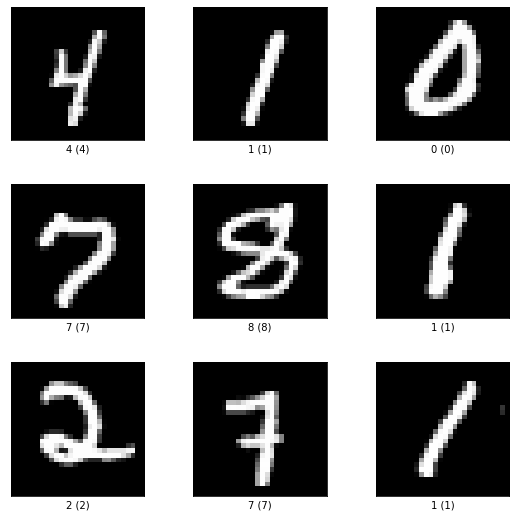

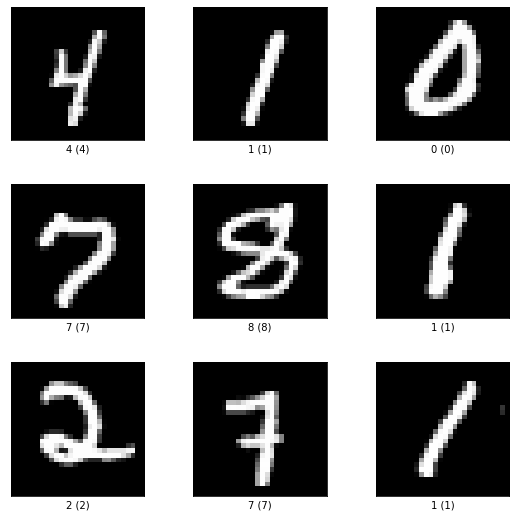

In [4]:
tfds.show_examples(train_ds, ds_info)

#### 2.2 Data pipeline

In [5]:
def prepare_mnist_data(mnist):
    #flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    #convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    #create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    #cache this progress in memory, as there is no need to redo it; it is deterministic after all
    mnist = mnist.cache()
    #shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    #return preprocessed dataset
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

#### 2.3 Deep Neural Network 

In [6]:
class FFNN(tf.keras.Model):
    
    def __init__(self):
        super(FFNN, self).__init__()
        # 2 hidden layers with 256 units each 
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        # 10 units for output layer since there are 10 digits to classify
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

#### 2.4 Training

In [7]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        accuracy = np.mean(accuracy)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy


def test(model, test_data, loss_function):
  # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [9]:
# hyperparameters
num_epochs = 10
learning_rate = 0.1

# model initialization 
model = FFNN()
# loss initialization (categorical cross entropy loss) 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# optimizer initialization (Stochastic Gradient Descent) 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# initialization lists for training
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

# testing on untrained model  
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# loss of untrained model
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input,target in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.08945686900958466
Epoch: 1 starting with accuracy 0.9566693290734825
Epoch: 2 starting with accuracy 0.959564696485623
Epoch: 3 starting with accuracy 0.9762380191693291
Epoch: 4 starting with accuracy 0.9725439297124601
Epoch: 5 starting with accuracy 0.9739416932907349
Epoch: 6 starting with accuracy 0.9678514376996805
Epoch: 7 starting with accuracy 0.9740415335463258
Epoch: 8 starting with accuracy 0.9767372204472844
Epoch: 9 starting with accuracy 0.9717452076677316


#### 2.5 Visualization

In [10]:
def visualization (train_losses, test_losses, test_accuracies, train_accuracies):
    z = np.linspace(0, 1, 11)
   
    
    line1 , = plt.plot(z, train_losses , "b-")
    line2 , = plt.plot(z, test_losses , "r-")
    line3 , = plt.plot(z, test_accuracies , "b:")
    line4 , = plt.plot(z, train_accuracies , "r:")
    
    plt.xlabel(" Training steps ")
    plt.ylabel(" Loss / Accuracy ")
    plt.legend(( line1 , line2 , line3, line4),(" training loss ", " test loss ", " test accuracy ", " train accuracy "))
    plt.show()

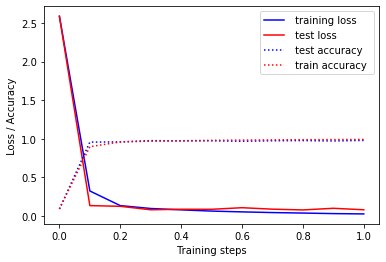

In [11]:
visualization(train_losses, test_losses ,test_accuracies, train_accuracies)

### Assignment 3 Hyperparameters

* original setting: jumps from 10% testing accuracy to 95% in the second epoch and then slowly gets better up to 97.5 % 

* learning_rate = 0.01 and added third dense layer: very similar to original setting but slightly lower accuracy is reached (lower learning_rate and additional layer seem to equal each other out?)

* learning_rate = 0.01, 2 dense layer with 500 units each: looks similar to the cases above 

* learning_rate = 0.01, 2 dense layer with 256, batch size = 12: looks similar again; runs a lot lower; accuracy did not change between epoch 3 and 4; and between 5 and 6 very low improvement; but continous improvement with no step-backs! and reaches highest accuracy in the end (only small difference but still the best so far)
